In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [4]:
del file_to_pages

In [5]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [6]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [7]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

In [8]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [11]:
# TRAINING_DATA = [
#     ["My little kitty is so special", {"KAT0": True}],
#     ["Dude, Totally, Yeah, Video Games", {"KAT1": True}],
#     ["Should I pay $1,000 for the iPhone X?", {"KAT1": True}],
#     ["The iPhone 8 reviews are here", {"KAT1": True}],
#     ["Noa is a great cat name.", {"KAT0": True}],
#     ["We got a new kitten!", {"KAT0": True}]
# ]

TRAINING_DATA = []
for idx in range(len(df_train)):
    cats = {}
    for a in range(1, 6):
        cats[str(a)] = 0
    cats[str(int(df_train.num_arms.iloc[idx]))] = 1
    text = df_train.text.iloc[idx]
    if len(text) > 1000000:
        text = text[:1000000]
    
    TRAINING_DATA.append([text , cats])

In [12]:
import spacy
# Add imports for example, as well as textcat config...
from spacy.training import Example
from spacy.pipeline.textcat import single_label_bow_config, single_label_default_config
from thinc.api import Config
import random

# labels should be one-hot encoded



# bow
# config = Config().from_str(single_label_bow_config)

# textensemble with attention
config = Config().from_str(single_label_default_config)

nlp = spacy.blank("en")
# now uses `add_pipe` instead
category = nlp.add_pipe("textcat", last=True, config=config)
for a in range(1, 6):
    category.add_label(str(a))


# Start the training
nlp.begin_training()

# Loop for 10 iterations
for itn in range(100):
    # Shuffle the training data
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Batch the examples and iterate over them
    for batch in spacy.util.minibatch(TRAINING_DATA, size=4):
        texts = [nlp.make_doc(text) for text, entities in batch]
        annotations = [{"cats": entities} for text, entities in batch]

        # uses an example object rather than text/annotation tuple
        examples = [Example.from_dict(doc, annotation) for doc, annotation in zip(
            texts, annotations
        )]
        nlp.update(examples, losses=losses)
    if itn % 20 == 0:
        print(losses)

{'textcat': 26.78331284970045}
{'textcat': 4.527130445936465}
{'textcat': 7.580678211299988}


KeyboardInterrupt: 

In [13]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [15]:
predictions = []
for idx in range(len(df_val)):
    doc = nlp(df_val.text.iloc[idx])
    predictions.append(doc.cats)

In [20]:
df_val["y_pred"] = [int(max(p, key=p.get)) for p in predictions]

/tmp/ipykernel_10914/2576098593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val["y_pred"] = [int(max(p, key=p.get)) for p in predictions]


In [22]:
num_arms_ground_truths = df_val.num_arms_clean
pred_num_arms = df_val["y_pred"]

In [23]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.4105263157894737


''

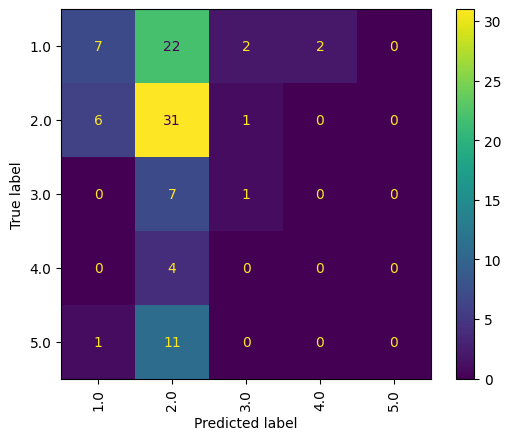

In [24]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;